In [1]:
#https://github.com/kmsravindra/ML-AI-experiments/blob/master/AI/Neural%20Machine%20Translation/Neural%20machine%20translation%20-%20Encoder-Decoder%20seq2seq%20model.ipynb
import os
"""
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)"""

from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Dropout
import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint
from keras import callbacks
#from sklearn.metrics import mean_squared_error
from time import gmtime, strftime

Using TensorFlow backend.


In [2]:
batch_size=128
epochs=3
train_path = "training_sets_split/"

In [3]:
network = "unidirectional"
datatype = "normal, transposed to A minor and C major"
stride = 4
encoder_dropout = False
decoder_dropout = True
dropout_encoder_amount = 0.2
dropout_decoder_amount = 0.2

timestamp = strftime("%d.%d.%y_%H:%M", gmtime())
folder_name = "trained_models/"+timestamp+"_"+network
weights_folder_name = folder_name + "/weights"
samples_folder_name = folder_name + "/samples"
history_folder_name = folder_name + "/history"
 
try:
    # Create target Directory
    os.mkdir(folder_name)
    print("Directory " , folder_name ,  " Created ") 
except FileExistsError:
    print("Directory " , folder_name ,  " already exists")
    
try:
    # Create target Directory
    os.mkdir(weights_folder_name)
    print("Directory " , weights_folder_name ,  " Created ") 
except FileExistsError:
    print("Directory " , weights_folder_name ,  " already exists")
    
try:
    # Create target Directory
    os.mkdir(samples_folder_name)
    print("Directory " , samples_folder_name ,  " Created ") 
except FileExistsError:
    print("Directory " , samples_folder_name ,  " already exists")

try:
    # Create target Directory
    os.mkdir(history_folder_name)
    print("Directory " , history_folder_name ,  " Created ") 
except FileExistsError:
    print("Directory " , history_folder_name ,  " already exists")

Directory  trained_models/13.13.18_11:12_unidirectional  Created 
Directory  trained_models/13.13.18_11:12_unidirectional/weights  Created 
Directory  trained_models/13.13.18_11:12_unidirectional/samples  Created 
Directory  trained_models/13.13.18_11:12_unidirectional/history  Created 


In [4]:
# Load dataset and create pairs of inputs and targets

with np.load(train_path+'split_inputs.npz') as split_inputs:
    inputs = split_inputs['train']
    
with np.load(train_path+'split_targets.npz') as split_targets:
    targets = split_targets['train']

print("Number of training inputs",len(inputs))
print("Number of training targets",len(targets))

# Print examples of inputs and targets
example_in = inputs[0]
example_target = targets[0]
print("Input example:", example_in)
print("Target example:", example_target)

Number of training inputs 8962
Number of training targets 8962
Input example: [ 60 129 129 129  67 129 129 129  64 129 129 129  60 129 129 129  67 129
 129 129  69 129 129 129  69 129 129 129  67 129 129 129]
Target example: [ 55 129 129 129  55 129 129 129  55 129 129 129  57 129 129 129  60 129
 129 129  65 129 129 129  65 129 129 129  64 129 129 129]


In [5]:
# Load test set
with np.load(train_path+'split_test_inputs.npz') as test_inputs:
    test_soprano_tenor = test_inputs['train']
with np.load(train_path+'split_test_targets.npz') as test_targets:
    test_alto_bass = test_targets['train']

In [6]:
# Make set of unique notes
split_inputs_uniq = np.unique(inputs)
split_targets_uniq = np.unique(targets)
test_soprano_tenor_uniq = np.unique(test_soprano_tenor)
test_alto_bass_uniq = np.unique(test_alto_bass)
input_set = set()
target_set = set()
for note in split_inputs_uniq:
    input_set.add(note)
    target_set.add(note)
for note in split_targets_uniq:
    input_set.add(note)
    target_set.add(note)
for note in test_soprano_tenor_uniq:
    input_set.add(note)
    target_set.add(note)
for note in test_alto_bass_uniq:
    input_set.add(note)
    target_set.add(note)
#target_set.add(200)
#target_set.add(201)

In [7]:
input_sequences = list(inputs)
target_sequences = []
#input_set = set()
#target_set = set()
num_samples = len(inputs)
    
for i in range(num_samples):    
    target_with_tokens = list(targets[i]) 
    target_sequences.append(target_with_tokens)

            
input_set = sorted(list(input_set))
target_set = sorted(list(target_set))
print("Set of input notes:\n", input_set)
print("Set of target notes:\n", target_set)

Set of input notes:
 [31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 128, 129]
Set of target notes:
 [31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 128, 129]


In [8]:
# dictionary to index each input note - key is index and value is the note
input_index_to_note_dict = {}

# dictionary to get note given its index - key is the note and value is the index
input_note_to_index_dict = {}

for k, v in enumerate(input_set):
    input_index_to_note_dict[k] = v
    input_note_to_index_dict[v] = k

In [9]:
# dictionary to index each target note - key is index and value is the note
target_index_to_note_dict = {}

# dictionary to get note given its index - key is the note and value is the index
target_note_to_index_dict = {}

for k, v in enumerate(target_set):
    target_index_to_note_dict[k] = v
    target_note_to_index_dict[v] = k

In [10]:
max_len_inputs = max([len(seq) for seq in input_sequences])
max_len_targets = max([len(line) for line in target_sequences])
print(max_len_inputs)
print(max_len_targets)

doc = []
doc.append("Network type:\t\t\t"+network)
doc.append("Dataset type:\t\t\t"+datatype)

if encoder_dropout:
    doc.append("Encoder dropout:\t\t{}".format(dropout_encoder_amount))
if decoder_dropout:
    doc.append("Decoder dropout:\t\t{}".format(dropout_decoder_amount))

doc.append("Batch size:\t\t\t{}".format(batch_size))
doc.append("Sample length:\t\t\t{}".format(max_len_inputs))
doc.append("Stride:\t\t\t\t{}".format(stride))
doc.append("Number of training inputs:\t{}".format(len(inputs)))
doc.append("Number of training targets:\t{}".format(len(targets)))
noteset = ' '.join(str(value) for value in input_set)
doc.append("Set of notes:\n " + noteset)


file = open(folder_name + "/Specifications.txt", "w")
file.write("\n".join(doc))
file.close()

32
32


In [11]:
tokenized_input_sequences = np.zeros(shape=(num_samples,max_len_inputs,len(input_set)), dtype='float32')
tokenized_target_sequences = np.zeros(shape=(num_samples,max_len_targets,len(target_set)), dtype='float32')
target_data = np.zeros((num_samples, max_len_targets, len(target_set)),dtype='float32')

In [12]:
for i in range(num_samples):
    for k, note_value in enumerate(input_sequences[i]):
        tokenized_input_sequences[i,k,input_note_to_index_dict[note_value]] = 1
    
    for k, note_value in enumerate(target_sequences[i]):
        tokenized_target_sequences[i,k,target_note_to_index_dict[note_value]] = 1
        
        # decoder_target_data will be ahead by one timestep and will not include the start character.
        if k > 0:
            target_data[i,k-1, target_note_to_index_dict[note_value]] = 1

In [13]:
# Encoder model

encoder_input = Input(shape=(None,len(input_set)))

if encoder_dropout:
    encoder_LSTM = LSTM(256,return_state = True, recurrent_dropout=dropout_encoder_amount)
else:
    encoder_LSTM = LSTM(256,return_state = True)

encoder_outputs, encoder_h, encoder_c = encoder_LSTM (encoder_input)
encoder_states = [encoder_h, encoder_c]

In [14]:
# Decoder model

decoder_input = Input(shape=(None,len(target_set)))

if decoder_dropout:
    decoder_LSTM = LSTM(256,return_sequences=True, return_state = True, recurrent_dropout=dropout_decoder_amount)
else:
    decoder_LSTM = LSTM(256,return_sequences=True, return_state = True)
decoder_out, _ , _ = decoder_LSTM(decoder_input, initial_state=encoder_states)
decoder_dense = Dense(len(target_set),activation='softmax')
decoder_out = decoder_dense (decoder_out)

In [15]:
filepath=weights_folder_name+"/{epoch:02d}-loss_{loss:.2f}-val_loss_{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min', save_best_only=False)
callbacks_list = [checkpoint]



In [16]:
model = Model(inputs=[encoder_input, decoder_input],outputs=[decoder_out])

# Run training
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [17]:
history = model.fit(x=[tokenized_input_sequences,tokenized_target_sequences], 
          y=target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,callbacks=callbacks_list)


Train on 7169 samples, validate on 1793 samples
Epoch 1/3
7169/7169 [==============================] - 53s 7ms/step - loss: 1.6961 - val_loss: 1.3161

Epoch 00001: saving model to trained_models/13.13.18_11:12_unidirectional/weights/01-loss_1.70-val_loss_1.32.hdf5


/home/torgrim/anaconda3/lib/python3.5/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/3
7169/7169 [==============================] - 53s 7ms/step - loss: 1.3510 - val_loss: 1.2261

Epoch 00002: saving model to trained_models/13.13.18_11:12_unidirectional/weights/02-loss_1.35-val_loss_1.23.hdf5
Epoch 3/3
7169/7169 [==============================] - 47s 6ms/step - loss: 1.1851 - val_loss: 1.1202

Epoch 00003: saving model to trained_models/13.13.18_11:12_unidirectional/weights/03-loss_1.19-val_loss_1.12.hdf5


In [18]:
# Save loss and validation loss
loss = np.array(history.history['loss'])
validation_loss = np.array(history.history['val_loss'])
loss_name = history_folder_name+'/loss.npz'
val_loss_name = history_folder_name+'/validation_loss.npz'
np.savez(loss_name, loss=loss)
np.savez(val_loss_name, loss=validation_loss)



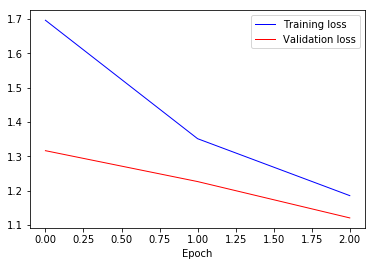

In [25]:
import matplotlib.pyplot as plt

with np.load(loss_name) as data:
    loss = list(data['loss'])
    
with np.load(val_loss_name) as data:
    val_loss = list(data['loss'])

epoch = np.arange(epochs)

plt.plot(epoch, loss, label="Training loss", color="blue", linewidth=1, linestyle="-")    # Add labels for the legend
plt.plot(epoch, val_loss, label="Validation loss", color="red", linewidth=1, linestyle="-")    # Add labels for the legend
plt.xlabel('Epoch')   # Add labels for the axis

plt.legend(loc=1)
plt.show()

In [19]:
# Load best weights
#model.load_weights("unidirectional.hdf5")

In [20]:
# Inference models for testing

# Encoder inference model
encoder_model_inf = Model(encoder_input, encoder_states)

# Decoder inference model
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_input_states = [decoder_state_input_h, decoder_state_input_c]

decoder_out, decoder_h, decoder_c = decoder_LSTM(decoder_input, 
                                                 initial_state=decoder_input_states)

decoder_states = [decoder_h , decoder_c]

decoder_out = decoder_dense(decoder_out)

decoder_model_inf = Model(inputs=[decoder_input] + decoder_input_states,
                          outputs=[decoder_out] + decoder_states )

In [21]:
def decode_seq(inp_seq, input_length):
    
    # Initial states value is coming from the encoder 
    states_val = encoder_model_inf.predict(inp_seq)
   
    target_seq = np.zeros((1, 1, len(target_set)))
    #target_seq[0, 0, target_note_to_index_dict[200]] = 1

    decoded_sequence = []
    stop_condition = False
    input_seq_length = len(inp_seq)
    
    while not stop_condition:       
        decoder_out, decoder_h, decoder_c = decoder_model_inf.predict(x=[target_seq] + states_val)      
        max_val_index = np.argmax(decoder_out[0,-1,:])
        sampled_note = target_index_to_note_dict[max_val_index]
        decoded_sequence.append(sampled_note)
        
        if len(decoded_sequence) == input_length:
        #if ((sampled_note == 201) or (len(decoded_sequence) > max_len_targets)):
            stop_condition = True
        
        target_seq = np.zeros((1, 1, len(target_set)))
        target_seq[0, 0, max_val_index] = 1
        
        states_val = [decoder_h, decoder_c]   
    return np.array(decoded_sequence)

In [22]:
# Sample with soprano and tenor from test set

with np.load(train_path+'test_inputs.npz') as test_targets:
    test_soprano_tenor = test_targets['train']
    
max_len_test_soprano_tenor = max([len(seq) for seq in test_soprano_tenor])
tokenized_inputs_sop_ten = np.zeros(shape=(len(test_soprano_tenor),max_len_test_soprano_tenor,len(input_set)), dtype='float32')  
    
for i in range(len(test_soprano_tenor)):
    for k, note_value in enumerate(test_soprano_tenor[i]):
        tokenized_inputs_sop_ten[i,k,input_note_to_index_dict[note_value]] = 1 


# Save all samples as file.
# Input sequences on even index and decoded sequences on odd index

samples = []
for seq_index, seq in enumerate(test_soprano_tenor):
    if seq_index % 10 == 0:
        print(seq_index)
    inp_seq = tokenized_inputs_sop_ten[seq_index:seq_index+1]
    input_seq_length = len(seq)
    decoded_sequence = decode_seq(inp_seq, input_seq_length)
    samples.append(test_soprano_tenor[seq_index])
    samples.append(decoded_sequence)
samples = np.array(samples)
np.savez(samples_folder_name+'/sampled_soprano_tenor.npz', samples=samples)
print(samples[0])
print(samples[1])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
[ 69 129 129 129  69 129 129 129  69 129 129 129  76 129 129 129 129 129
  74 129  72 129 129 129  76 129 129 129  74 129 129 129  72 129 129 129
  71 129 129 129 129 129 129 129 129 129 129 129  76 129 129 129  76 129
 129 129  78 129 129 129  79 129 129 129 129 129 129 129  78 129 129 129
  76 129 129 129  75 129 129 129 129 129 129 129  76 129 129 129 129 129
 129 129 129 129 129 129  76 129 129 129  74 129 129 129  71 129 129 129
  72 129 129 129 129 129  74 129  76 129 129 129  74 129 129 129  72 129
 129 129]
[129 129 129 129 129 129 129 129 129 129 129 129 129 129 129 129 129 129
 129 129 129 129 129 129 129 129 129 129 129 129 129 129 129 129 129 129
 129 129 129 129 129 129 129 129 129 129 129 129 129 129 129 129 129 129
 129 129 129 129 129 129 129 129 129 129 129 129 129 129 129 129 129 129
 129 129 129 129 129 129 129 129 129 129 129 129 129 129 129 129 129 129
 129 129 129 129 129 129 129 129 129 129 129 129 129 129 129 

In [23]:
# Sample with alto and bass from test set

with np.load(train_path+'test_targets.npz') as test_targets:
    test_alto_bass = test_targets['train']

max_len_test_alto_bass = max([len(seq) for seq in test_alto_bass])
tokenized_inputs_alt_bas = np.zeros(shape=(len(test_alto_bass),max_len_test_alto_bass,len(input_set)), dtype='float32')  
    
for i in range(len(test_soprano_tenor)):
    for k, note_value in enumerate(test_alto_bass[i]):
        tokenized_inputs_alt_bas[i,k,input_note_to_index_dict[note_value]] = 1 


# Save all samples as file.
# Input sequences on even index and decoded sequences on odd index

#folder_name = "/home/torgrim/master/IN5490/model/in5490/ferdig_trent/Session_normal_dataset_unidirectional_09.09.18_17_38"

samples = []
for seq_index, seq in enumerate(test_alto_bass):
    if seq_index % 10 == 0:
        print(seq_index)
    inp_seq = tokenized_inputs_alt_bas[seq_index:seq_index+1]
    input_seq_length = len(seq)
    decoded_sequence = decode_seq(inp_seq, input_seq_length)
    samples.append(test_alto_bass[seq_index])
    samples.append(decoded_sequence)
samples = np.array(samples)
np.savez(samples_folder_name+'/sampled_alto_bass.npz', samples=samples)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
